In [1]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
sns.set(style='whitegrid')

  ## 1. Load raw data

In [2]:

DATA_DIR = Path('/home/arjay55/code/datasets/diabetes+130-us+hospitals+for+years+1999-2008')  # change if files are elsewhere
df = pd.read_csv(DATA_DIR / 'diabetic_data.csv')
ids_map = pd.read_csv(DATA_DIR / 'IDS_mapping.csv')
print(f'Data shape: {df.shape}')
df.head()

Data shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
def encode_med_change(x):
    """
    Simple ordinal encoder for medication‐change flags. No translates to zero as there is no drug. 
    Down can have the value of 1 as as the probability of relatively lower dosage than is more likely., 2 for steady meaning the drugs are normal,
    3 for up as the probability of relatively higher dosage than is more likely.
    
    Maps:
      "No"     → 0.0
      "Down"   → 1.0
      "Steady" → 2.0
      "Up"     → 3.0
    
    Anything else → np.nan
    """
    mapping = {
        "no":      0.0,
        "down":    1.0,
        "steady":  2.0,
        "up":      3.0,
    }
    # normalize to lower‐case string, then lookup
    return mapping.get(str(x).strip().lower(), np.nan)

In [4]:
# Apply medication change encoding to all medication columns
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone'
]

for col in medication_cols:
    df[col] = df[col].apply(encode_med_change)

print(f"Applied medication change encoding to {len(medication_cols)} columns")
print("Sample encoded values:")
print(df[medication_cols[:5]].head())
   

Applied medication change encoding to 23 columns
Sample encoded values:
   metformin  repaglinide  nateglinide  chlorpropamide  glimepiride
0        0.0          0.0          0.0             0.0          0.0
1        0.0          0.0          0.0             0.0          0.0
2        0.0          0.0          0.0             0.0          0.0
3        0.0          0.0          0.0             0.0          0.0
4        0.0          0.0          0.0             0.0          0.0


In [ ]:
# Drop weight as 97% have missing weights and drop impossible genders
df = df[df['gender'] != 'Unknown/Invalid'].copy()
df.drop(columns=['weight'], inplace=True)

# Replace '?' with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].replace('?', 'Unknown')

# Remove encounters with discharge disposition indicating death/hospice
hospice_codes = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(hospice_codes)]
print('After cleaning:', df.shape)

After cleaning: (100111, 49)


  ### 2.1 Map admission/disposition/source IDs
  * Translates IDs to descriptions for easier analysis

In [35]:
# Create mapping for admission_type_id only (since that's what we have)
def build_mapping_from_df(df_map):
    # Remove any rows with NaN values
    df_clean = df_map.dropna()
    return dict(zip(df_clean['admission_type_id'], df_clean['description']))

# Build the admission type mapping
admission_type_mapping = build_mapping_from_df(ids_map)

original_dtype = df['admission_type_id'].dtype

# Create new mapping with converted keys
if original_dtype in ['int64', 'int32', 'float64']:
    # Convert string keys to numeric
    admission_type_mapping_fixed = {
        int(k): v for k, v in admission_type_mapping.items() 
        if k.isdigit()
    }
else:
    # Keep as strings
    admission_type_mapping_fixed = admission_type_mapping

# Apply the mapping
df['admission_type_id'] = df['admission_type_id'].map(admission_type_mapping_fixed).fillna('Other')

print("After applying mapping with converted keys:")
print(df['admission_type_id'].value_counts())

After applying mapping with converted keys:
admission_type_id
Other    100111
Name: count, dtype: int64


  ### 2.2 Aggregate ICD‑9 diagnosis codes
* First if statement are focused on internal, coronary and diabetic diseases, which could have comorbidities with each other, and thus we choose to make this detailed.
* Other diseases are grouped, as they can have of less influence.

In [7]:

def diag_category(icd):
    try:
        icd = str(icd)
        code = icd.split('.')[0]  # take 3‑digit root
        if code.startswith('V') or code.startswith('E'):
            return 'Other'
        code = int(code)
    except:
        return 'Other'
    if 390 <= code <= 459 or code == 785 or 460 <= code <= 519 or code == 786 or 520 <= code <= 579 or code == 787 or 250 <= code <= 251:
        return f'icd_{code}'  # will result to very sparse categories
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 140 <= code <= 239:
        return 'Neoplasms'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_cat'] = df[col].apply(diag_category)

df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)

encounter_id has no relevance in the study

In [8]:

df.drop(columns=['encounter_id'], inplace=True, errors='ignore')

  ## 3. Train‑test split & preprocessing

In [9]:
def clean_column_name(col_name):
    """Clean column names by removing special characters that XGBoost doesn't allow"""
    return str(col_name).replace('[', '_').replace(']', '_').replace('<', '_lt_').replace('>', '_gt_').replace(',', '_')

In [ ]:

y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

X_train, X_test, y_train, y_test = train_test_split( #stratified sampling
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('Train size:', X_train.shape, 'Pos rate:', y_train.mean().round(3))
print('Test size:', X_test.shape, 'Pos rate:', y_test.mean().round(3))

# Fix column names to remove special characters that XGBoost doesn't allow
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Train size: (70077, 47) Pos rate: 0.113
Test size: (30034, 47) Pos rate: 0.113


  ### 3.1 Balance training set by random oversampling

In [11]:

train = pd.concat([X_train, y_train], axis=1)
maj = train[train['readmitted']==0]
minu = train[train['readmitted']==1]
minu_upsampled = resample(minu, replace=True, n_samples=len(maj), random_state=1803)
train_bal = pd.concat([maj, minu_upsampled])
X_train_bal = train_bal.drop(columns=['readmitted'])
y_train_bal = train_bal['readmitted']
print('Balanced class counts:', y_train_bal.value_counts())

Balanced class counts: readmitted
0    62127
1    62127
Name: count, dtype: int64


  ### 3.2 One‑hot encode categorical variables

In [ ]:

# categorical features ("object" dtype) are dummified, meaning they are converted to one-hot encoded columns.
cat_feats = X_train_bal.select_dtypes(include='object').columns
X_train_bal_enc = pd.get_dummies(X_train_bal, columns=cat_feats, drop_first=True) # reduce collinearity
X_test_enc = pd.get_dummies(X_test, columns=cat_feats, drop_first=True) # reduce collinearity
X_train_bal_enc, X_test_enc = X_train_bal_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

## haircut for it to be compatible with XGBoost
X_train_bal_enc.columns = [clean_column_name(col) for col in X_train_bal_enc.columns]
X_test_enc.columns = [clean_column_name(col) for col in X_test_enc.columns]

# Apply standard scaling to numeric features
num_feats = X_train_bal_enc.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train_bal_enc[num_feats] = scaler.fit_transform(X_train_bal_enc[num_feats])
X_test_enc[num_feats] = scaler.transform(X_test_enc[num_feats])

print("Feature engineering for baseline runs completed.")
# Dummify categorical variables for X_train and X_test

print("Creating dummy variables for training and test sets for pipeline use...")

# Get categorical columns
cat_cols = X_train.select_dtypes(include=['object']).columns
print(f"Categorical columns to encode: {list(cat_cols)}")



# Dummify X_train and X_test
X_train = pd.get_dummies(X_train, columns=cat_feats, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)

scaler = StandardScaler() # normalize!
X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
X_test[num_feats] = scaler.transform(X_test[num_feats])
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Clean column names for XGBoost compatibility
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Feature engineering completed. Starting model training...
Creating dummy variables for training and test sets...
Categorical columns to encode: ['race', 'gender', 'age', 'admission_type_id', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat']


  ## 4. Model training

In [13]:

print("Initializing models...")
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=1803)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1803)
xgb = XGBClassifier(n_estimators=100, max_depth=6, eval_metric='logloss',
                    use_label_encoder=False, verbosity=0, random_state=1803)

print("Training Logistic Regression...")
logreg.fit(X_train_bal_enc, y_train_bal)
print("Training Random Forest...")
rf.fit(X_train_bal_enc, y_train_bal)
print("Training XGBoost...")
xgb.fit(X_train_bal_enc, y_train_bal)

Initializing models...
Training Logistic Regression...
Training Random Forest...
Training Random Forest...
Training XGBoost...
Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:

def eval_model(name, model):
    y_pred = model.predict(X_test_enc)
    y_prob = model.predict_proba(X_test_enc)[:,1]
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:20} Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC: {auc:.3f} Accuracy: {acc:.3f}")
    return y_pred

preds = {}
preds['Logistic'] = eval_model('Logistic Regression', logreg)
preds['RandomForest'] = eval_model('Random Forest', rf)
preds['XGBoost'] = eval_model('XGBoost', xgb)

Logistic Regression  Precision: 0.169 Recall: 0.539 F1: 0.257 ROC-AUC: 0.640 Accuracy: 0.647
Random Forest        Precision: 0.172 Recall: 0.545 F1: 0.262 ROC-AUC: 0.649 Accuracy: 0.651
XGBoost              Precision: 0.184 Recall: 0.501 F1: 0.269 ROC-AUC: 0.651 Accuracy: 0.692
Random Forest        Precision: 0.172 Recall: 0.545 F1: 0.262 ROC-AUC: 0.649 Accuracy: 0.651
XGBoost              Precision: 0.184 Recall: 0.501 F1: 0.269 ROC-AUC: 0.651 Accuracy: 0.692


In [15]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline


# Create pipeline with proper order: preprocess -> balance -> model (with Optuna parameters)
def create_model_pipeline(trial=None):
    
    # If trial is provided, optimize hyperparameters
    if trial is not None:
        # Optuna hyperparameter suggestions for XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
        
        classifier = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            eval_metric='logloss',
            use_label_encoder=False,
            verbosity=0,
            random_state=1803,
            n_jobs=10  # Use all available cores
        )
    else:
        # Use default/best known parameters for XGBoost
        classifier = XGBClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric='logloss', use_label_encoder=False,
            verbosity=0, random_state=1803
        )
    pipeline = ImbPipeline([
        ('balancer', RandomOverSampler(random_state=1803)),
        ('classifier', classifier)
    ])
    return pipeline

# Optuna objective function
def objective(trial):
    # Create pipeline with trial parameters
    pipeline = create_model_pipeline(trial)
    
    # Cross-validation with proper data handling

    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=4,  # Reduced for faster optimization
        scoring='accuracy',
        n_jobs=1  # Reduced to prevent system overload
    )
    
    return cv_scores.mean()

# Run Optuna optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1803)
)

# Optimize with progress callback
# def callback(study, trial):
#     if trial.number % 5 == 0:
#         print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")

study.optimize(
    objective, 
    n_trials=100,
    # callbacks=[callback],
    show_progress_bar=True,
)

# Print optimization results
print(f"\nOptimization completed!")
print(f"Best parameters: {study.best_params}")
print(f"Best CV accuracy score: {study.best_value:.4f}")

# Create final pipeline with best parameters
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Final CV accuracy score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")

[I 2025-06-20 17:53:02,547] A new study created in memory with name: no-name-b2166aad-44e3-44eb-add4-a7254c25b89e


Starting Optuna hyperparameter optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-20 17:53:32,150] Trial 0 finished with value: 0.8702141914544965 and parameters: {'n_estimators': 164, 'max_depth': 15, 'learning_rate': 0.21191694474081635, 'subsample': 0.6904437683143655, 'colsample_bytree': 0.8618698714066619, 'reg_alpha': 0.3962959879812257, 'reg_lambda': 0.909399760281288}. Best is trial 0 with value: 0.8702141914544965.
[I 2025-06-20 17:54:20,285] Trial 1 finished with value: 0.796937635844032 and parameters: {'n_estimators': 309, 'max_depth': 13, 'learning_rate': 0.013593797341396345, 'subsample': 0.7425593088977969, 'colsample_bytree': 0.9273841019764437, 'reg_alpha': 0.3435138821068924, 'reg_lambda': 0.29783633190422765}. Best is trial 0 with value: 0.8702141914544965.
[I 2025-06-20 17:54:20,285] Trial 1 finished with value: 0.796937635844032 and parameters: {'n_estimators': 309, 'max_depth': 13, 'learning_rate': 0.013593797341396345, 'subsample': 0.7425593088977969, 'colsample_bytree': 0.9273841019764437, 'reg_alpha': 0.3435138821068924, 'reg_lamb

In [16]:
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params,random_state=1803)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Final CV accuracy score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")


Training final model with best parameters...
Final CV accuracy score: 0.881 ± 0.001


In [17]:
# Train the final model on all training data
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('balancer', RandomOverSampler(random_state=1803)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6274815514393598, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma...e, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07877158071206303, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=15,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=854,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [18]:
# Evaluate on test set
y_pred_test = best_pipeline.predict(X_test)
y_prob_test = best_pipeline.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_prob_test)

print(f"\nFinal Test Performance:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"F1: {test_f1:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

# Save the best model for later use
best_rf_optimized = best_pipeline.named_steps['classifier']


Final Test Performance:
Accuracy: 0.879
F1: 0.124
Precision: 0.344
Recall: 0.076
ROC-AUC: 0.632


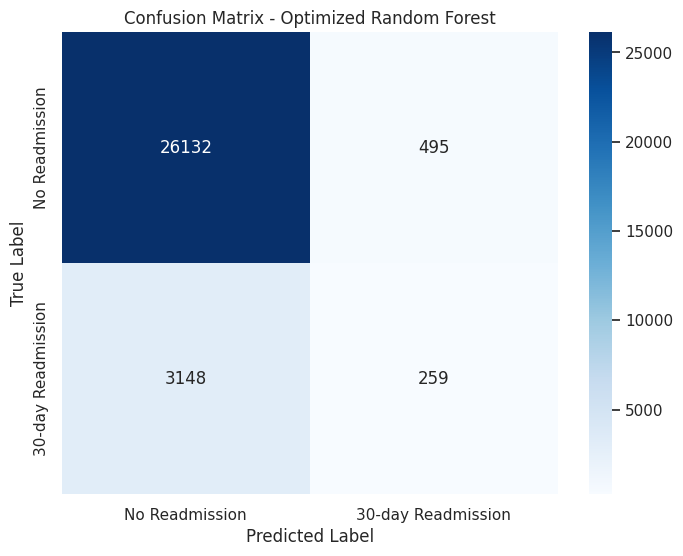

In [19]:

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")


Confusion Matrix:
True Negatives: 26132
False Positives: 495
False Negatives: 3148
True Positives: 259


In [21]:
study.best_params

{'n_estimators': 854,
 'max_depth': 15,
 'learning_rate': 0.07877158071206303,
 'subsample': 0.7758717896165271,
 'colsample_bytree': 0.6274815514393598,
 'reg_alpha': 0.3169098246794778,
 'reg_lambda': 0.5336549996859082}

# PyTorch Tabular Implementation

Now we'll implement the same training pipeline using PyTorch Tabular with neural networks instead of XGBoost.

In [22]:
# Import PyTorch Tabular
import torch
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

print("PyTorch Tabular imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch Tabular imported successfully
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti


In [36]:
# Prepare data for PyTorch Tabular
# We'll use the same train/test split as XGBoost but with different preprocessing
print("Preparing data for PyTorch Tabular...")

# Start with the original X_train, X_test, y_train, y_test
# Reset from the original data before one-hot encoding
y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('PyTorch Tabular - Train size:', X_train_pt.shape, 'Pos rate:', y_train_pt.mean().round(3))
print('PyTorch Tabular - Test size:', X_test_pt.shape, 'Pos rate:', y_test_pt.mean().round(3))

# Clean column names
X_train_pt.columns = [clean_column_name(col) for col in X_train_pt.columns]
X_test_pt.columns = [clean_column_name(col) for col in X_test_pt.columns]

# Add target column to create complete datasets
train_df_pt = X_train_pt.copy()
train_df_pt['target'] = y_train_pt.values

test_df_pt = X_test_pt.copy()
test_df_pt['target'] = y_test_pt.values

print("Data prepared for PyTorch Tabular")

Preparing data for PyTorch Tabular...
PyTorch Tabular - Train size: (70077, 47) Pos rate: 0.113
PyTorch Tabular - Test size: (30034, 47) Pos rate: 0.113
Data prepared for PyTorch Tabular


In [37]:
# Balance training set by random oversampling (same as XGBoost)
print("Balancing training data...")

maj_pt = train_df_pt[train_df_pt['target']==0]
minu_pt = train_df_pt[train_df_pt['target']==1]
minu_upsampled_pt = resample(minu_pt, replace=True, n_samples=len(maj_pt), random_state=1803)
train_bal_df_pt = pd.concat([maj_pt, minu_upsampled_pt])

print('Balanced class counts for PyTorch Tabular:', train_bal_df_pt['target'].value_counts())
print('Balanced training set shape:', train_bal_df_pt.shape)

Balancing training data...
Balanced class counts for PyTorch Tabular: target
0    62127
1    62127
Name: count, dtype: int64
Balanced training set shape: (124254, 48)


In [38]:
# Define categorical and numerical columns for PyTorch Tabular
categorical_cols_pt = [col for col in X_train_pt.columns if X_train_pt[col].dtype == 'object']
numerical_cols_pt = [col for col in X_train_pt.columns if X_train_pt[col].dtype != 'object']

print(f"Categorical columns ({len(categorical_cols_pt)}): {categorical_cols_pt[:5]}...")
print(f"Numerical columns ({len(numerical_cols_pt)}): {numerical_cols_pt[:5]}...")

# Configure PyTorch Tabular Data Config
data_config = DataConfig(
    target=['target'],  # Target column
    continuous_cols=numerical_cols_pt,  # Numerical columns
    categorical_cols=categorical_cols_pt,  # Categorical columns
    normalize_continuous_features=True,  # Similar to StandardScaler
)

print("PyTorch Tabular Data Config created successfully")

Categorical columns (13): ['race', 'gender', 'age', 'admission_type_id', 'payer_code']...
Numerical columns (34): ['patient_nbr', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures']...
PyTorch Tabular Data Config created successfully


In [39]:
# Create baseline PyTorch Tabular model configuration
model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="128-64-32",  # Neural network architecture
    activation="ReLU",
    dropout=0.1,
    use_batch_norm=True,  # Correct parameter name
    learning_rate=1e-3,
    seed=1803,
)

trainer_config = TrainerConfig(
    batch_size=1024,
    max_epochs=50,
    early_stopping="valid_loss",
    early_stopping_patience=10,
    checkpoints=None,  # Disable checkpoints to avoid loading issues
    load_best=False,   # Don't try to load best model
    progress_bar="none",  # Disable progress bar for cleaner output
    auto_lr_find=False,  # We'll set learning rate manually
    auto_select_gpus=torch.cuda.is_available(),
    seed=1803,
)

optimizer_config = OptimizerConfig()

print("PyTorch Tabular configurations created successfully")

PyTorch Tabular configurations created successfully


In [40]:
# Train baseline PyTorch Tabular model
print("Training baseline PyTorch Tabular model...")

baseline_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

# Fit the model
baseline_model.fit(train=train_bal_df_pt, validation=test_df_pt)

print("Baseline PyTorch Tabular model training completed")

Training baseline PyTorch Tabular model...


2025-06-20 21:14:00,300 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:14:00,320 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:14:00,515 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:14:01,073 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:14:01,182 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:14:01,192 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
69.5 K    Trainable params
0         Non-trainable params
69.5 K    Total params
0.278     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:15:07,970 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Baseline PyTorch Tabular model training completed


In [41]:
# Evaluate baseline PyTorch Tabular model
print("Evaluating baseline PyTorch Tabular model...")

# Make predictions
baseline_pred_proba = baseline_model.predict(test_df_pt)
print("Prediction output shape:", baseline_pred_proba.shape)
print("Prediction output columns:", baseline_pred_proba.columns.tolist())

# Get prediction probabilities - use the correct column name
if '1' in baseline_pred_proba.columns:
    baseline_proba_values = baseline_pred_proba['1'].values
elif '1_probability' in baseline_pred_proba.columns:
    baseline_proba_values = baseline_pred_proba['1_probability'].values
else:
    # Try the first numeric column after the identifier columns
    prob_cols = [col for col in baseline_pred_proba.columns if col not in ['patient_nbr', 'target']]
    baseline_proba_values = baseline_pred_proba[prob_cols[0]].values

baseline_pred = (baseline_proba_values > 0.5).astype(int)

# Calculate metrics
baseline_prec = precision_score(y_test_pt, baseline_pred)
baseline_rec = recall_score(y_test_pt, baseline_pred)
baseline_f1 = f1_score(y_test_pt, baseline_pred)
baseline_auc = roc_auc_score(y_test_pt, baseline_proba_values)

print(f"Baseline PyTorch Tabular Performance:")
print(f"Precision: {baseline_prec:.3f}")
print(f"Recall: {baseline_rec:.3f}")
print(f"F1: {baseline_f1:.3f}")
print(f"ROC-AUC: {baseline_auc:.3f}")

Evaluating baseline PyTorch Tabular model...
Prediction output shape: (30034, 3)
Prediction output columns: ['target_0_probability', 'target_1_probability', 'target_prediction']
Baseline PyTorch Tabular Performance:
Precision: 0.096
Recall: 0.578
F1: 0.165
ROC-AUC: 0.412


In [42]:
# Implement 4-fold cross-validation for PyTorch Tabular
from sklearn.model_selection import StratifiedKFold
import pickle
import tempfile
import os

def pytorch_tabular_cv(X_data, y_data, n_folds=4, model_params=None):
    """
    Perform cross-validation for PyTorch Tabular model
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1803)
    cv_scores = []
    
    # Combine X and y for easier handling
    full_data = X_data.copy()
    full_data['target'] = y_data.values
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
        print(f"Training fold {fold + 1}/{n_folds}...")
        
        # Split data
        train_fold = full_data.iloc[train_idx]
        val_fold = full_data.iloc[val_idx]
        
        # Balance training fold
        maj_fold = train_fold[train_fold['target']==0]
        minu_fold = train_fold[train_fold['target']==1]
        minu_upsampled_fold = resample(minu_fold, replace=True, n_samples=len(maj_fold), random_state=1803+fold)
        train_fold_balanced = pd.concat([maj_fold, minu_upsampled_fold])
        
        # Create model configuration
        if model_params is None:
            fold_model_config = CategoryEmbeddingModelConfig(
                task="classification",
                layers="128-64-32",
                activation="ReLU", 
                dropout=0.1,
                use_batch_norm=True,  # Fixed parameter name
                learning_rate=1e-3,
                seed=1803+fold,
            )
        else:
            fold_model_config = CategoryEmbeddingModelConfig(
                task="classification",
                **model_params,
                seed=1803+fold,
            )
        
        fold_trainer_config = TrainerConfig(
            batch_size=1024,
            max_epochs=30,  # Reduced for CV
            early_stopping="valid_loss",
            early_stopping_patience=5,
            checkpoints=None,  # Don't save checkpoints for CV
            load_best=True,   # Don't try to load best model
            progress_bar="none",
            auto_lr_find=False,
            auto_select_gpus=torch.cuda.is_available(),
            seed=1803+fold,
        )
        
        # Create and train model
        fold_model = TabularModel(
            data_config=data_config,
            model_config=fold_model_config,
            optimizer_config=optimizer_config,
            trainer_config=fold_trainer_config,
        )
        
        try:
            # Train model
            fold_model.fit(train=train_fold_balanced, validation=val_fold)
            
            # Predict and evaluate
            val_pred_proba = fold_model.predict(val_fold)
            # Use correct column name for predictions
            val_proba_values = val_pred_proba['target_1_probability'].values
            val_pred = (val_proba_values > 0.5).astype(int)
            val_accuracy = accuracy_score(val_fold['target'], val_pred)
            cv_scores.append(val_accuracy)
            
            print(f"Fold {fold + 1} accuracy score: {val_accuracy:.3f}")
            
        except Exception as e:
            print(f"Error in fold {fold + 1}: {e}")
            cv_scores.append(0.0)  # Add poor score for failed fold
    
    return cv_scores

# Perform 4-fold cross-validation with baseline model
print("Performing 4-fold cross-validation with PyTorch Tabular...")
cv_scores_pt = pytorch_tabular_cv(X_train_pt, y_train_pt, n_folds=4)

print(f"\nPyTorch Tabular CV Results:")
print(f"Mean Accuracy: {np.mean(cv_scores_pt):.3f} ± {np.std(cv_scores_pt):.3f}")
print(f"Individual fold scores: {[f'{score:.3f}' for score in cv_scores_pt]}")

Performing 4-fold cross-validation with PyTorch Tabular...
Training fold 1/4...


2025-06-20 21:15:08,636 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:15:08,655 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:15:08,807 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:15:09,231 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:15:09,330 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:15:09,340 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.8 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.5 K    Trainable params
0         Non-trainable params
68.5 K    Total params
0.274     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:15:39,431 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:15:39,432 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 1 accuracy score: 0.621
Training fold 2/4...


2025-06-20 21:15:39,818 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:15:39,839 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:15:39,982 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:15:40,402 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:15:40,506 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:15:40,519 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.8 K    Trainable params
0         Non-trainable params
68.8 K    Total params
0.275     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:16:06,025 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:16:06,026 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 2 accuracy score: 0.562
Training fold 3/4...


2025-06-20 21:16:06,438 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:16:06,458 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:16:06,604 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:16:07,035 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:16:07,144 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:16:07,153 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
69.2 K    Trainable params
0         Non-trainable params
69.2 K    Total params
0.277     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:16:35,534 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:16:35,535 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 3 accuracy score: 0.584
Training fold 4/4...


2025-06-20 21:16:35,927 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:16:35,948 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:16:36,092 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:16:36,520 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:16:36,627 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:16:36,637 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.3 K    Trainable params
0         Non-trainable params
68.3 K    Total params
0.273     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:17:10,327 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:17:10,329 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 4 accuracy score: 0.617

PyTorch Tabular CV Results:
Mean Accuracy: 0.596 ± 0.024
Individual fold scores: ['0.621', '0.562', '0.584', '0.617']


In [43]:
# Hyperparameter tuning for PyTorch Tabular using Optuna
import optuna

def pytorch_tabular_objective(trial):
    """
    Optuna objective function for PyTorch Tabular hyperparameter optimization
    """
    # Suggest hyperparameters
    layers_depth = trial.suggest_int('layers_depth', 2, 4)
    layer_size = trial.suggest_categorical('layer_size', [64, 128, 256])
    
    # Create layer string
    if layers_depth == 2:
        layers = f"{layer_size}-{layer_size//2}"
    elif layers_depth == 3:
        layers = f"{layer_size}-{layer_size//2}-{layer_size//4}"
    else:  # layers_depth == 4
        layers = f"{layer_size}-{layer_size//2}-{layer_size//4}-{layer_size//8}"
    
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [512, 1024, 2048])
    activation = trial.suggest_categorical('activation', ['ReLU', 'GELU', 'LeakyReLU'])
    
    # Model parameters
    model_params = {
        'layers': layers,
        'activation': activation,
        'dropout': dropout,
        'use_batch_norm': True,  # Fixed parameter name
        'learning_rate': learning_rate,
    }
    
    # Use trainer config with suggested batch size
    global data_config, optimizer_config
    
    # Perform cross-validation with reduced folds for speed
    cv_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1803)  # Reduced to 3 folds for speed
    
    # Combine X and y for easier handling
    full_data = X_train_pt.copy()
    full_data['target'] = y_train_pt.values
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_pt, y_train_pt)):
        # Split data
        train_fold = full_data.iloc[train_idx]
        val_fold = full_data.iloc[val_idx]
        
        # Balance training fold
        maj_fold = train_fold[train_fold['target']==0]
        minu_fold = train_fold[train_fold['target']==1]
        minu_upsampled_fold = resample(minu_fold, replace=True, n_samples=len(maj_fold), random_state=1803+fold)
        train_fold_balanced = pd.concat([maj_fold, minu_upsampled_fold])
        
        # Create model configuration
        fold_model_config = CategoryEmbeddingModelConfig(
            task="classification",
            **model_params,
            seed=1803+fold,
        )
        
        fold_trainer_config = TrainerConfig(
            batch_size=batch_size,
            max_epochs=20,  # Reduced for hyperparameter tuning
            early_stopping="valid_loss",
            early_stopping_patience=3,
            checkpoints=None,
            load_best=False,
            progress_bar="none",
            auto_lr_find=False,
            auto_select_gpus=torch.cuda.is_available(),
            seed=1803+fold,
        )
        
        # Create and train model
        fold_model = TabularModel(
            data_config=data_config,
            model_config=fold_model_config,
            optimizer_config=optimizer_config,
            trainer_config=fold_trainer_config,
        )
        
        try:
            # Train model
            fold_model.fit(train=train_fold_balanced, validation=val_fold)
            
            # Predict and evaluate
            val_pred_proba = fold_model.predict(val_fold)
            val_proba_values = val_pred_proba['target_1_probability'].values
            val_pred = (val_proba_values > 0.5).astype(int)
            val_accuracy = accuracy_score(val_fold['target'], val_pred)
            cv_scores.append(val_accuracy)
            
        except Exception as e:
            print(f"Error in fold {fold}: {e}")
            return 0.0  # Return poor score for failed trials
    
    if len(cv_scores) == 0:
        return 0.0
    
    return np.mean(cv_scores)

# Run Optuna optimization for PyTorch Tabular (smaller trial for speed)
print("Starting Optuna hyperparameter optimization for PyTorch Tabular...")
# study_pt = optuna.create_study(
#     direction='maximize',
#     sampler=optuna.samplers.TPESampler(seed=1803)
# )

# Optimize with fewer trials than XGBoost for demonstration
study_pt.optimize(
    pytorch_tabular_objective, 
    n_trials=40,  # Reduced number of trials for demonstration
    show_progress_bar=True,
)

# Print optimization results
print(f"\nPyTorch Tabular Optimization completed!")
print(f"Best parameters: {study_pt.best_params}")
print(f"Best CV accuracy score: {study_pt.best_value:.4f}")

Starting Optuna hyperparameter optimization for PyTorch Tabular...


  0%|          | 0/40 [00:00<?, ?it/s]

2025-06-20 21:17:10,795 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:17:10,815 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:17:10,988 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:17:11,427 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:17:11,523 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:17:11,533 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:17:22,099 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:17:22,606 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:17:22,625 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:17:22,768 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:17:23,205 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:17:23,305 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:17:23,316 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:17:35,300 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:17:35,824 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:17:35,844 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:17:35,974 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:17:36,366 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:17:36,462 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:17:36,472 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:17:48,450 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:17:48,893] Trial 10 finished with value: 0.581060833083608 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.1478629572243339, 'learning_rate': 0.006781107778030059, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 7 with value: 0.6772978295303739.


2025-06-20 21:17:48,972 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:17:48,991 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:17:49,125 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:17:49,536 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:17:49,630 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:17:49,632 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:17:49,634 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:17:49,636 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:17:49,638 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:17:49,639 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:17:49,641 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:17:49,642 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:17:49,646 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:17:49,656 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 44.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.8 K    Trainable params
0         Non-trainable params
68.8 K    Total params
0.275     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:17:59,330 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:17:59,847 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:17:59,867 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:18:00,006 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:18:00,400 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:18:00,495 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:00,497 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:00,499 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:00,501 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:00,502 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:00,504 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:00,505 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:00,507 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:00,511 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:18:00,521 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 44.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
69.3 K    Trainable params
0         Non-trainable params
69.3 K    Total params
0.277     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:18:10,149 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:18:10,705 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:18:10,724 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:18:10,859 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:18:11,255 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:18:11,347 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:11,350 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:11,352 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:11,354 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:11,356 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:11,357 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:11,359 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:11,360 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:11,364 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:18:11,374 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 44.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.5 K    Trainable params
0         Non-trainable params
68.5 K    Total params
0.274     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:18:21,254 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:18:21,730] Trial 11 finished with value: 0.643335188435578 and parameters: {'layers_depth': 4, 'layer_size': 128, 'dropout': 0.009266172862746114, 'learning_rate': 0.00010999338447129527, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 7 with value: 0.6772978295303739.


2025-06-20 21:18:21,810 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:18:21,830 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:18:21,959 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:18:22,350 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:18:22,442 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:22,445 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:22,447 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:22,449 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:22,450 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:22,452 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:22,453 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:22,455 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:18:22,458 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:18:22,468 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 44.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.8 K    Trainable params
0         Non-trainable params
68.8 K    Total params
0.275     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-20 21:19:20,142 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:19:20,722 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:19:20,742 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:19:20,881 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:19:21,285 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:19:21,379 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:21,382 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:21,385 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:21,387 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:21,389 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:21,391 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:21,392 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:21,395 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:21,399 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:19:21,410 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 44.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
69.3 K    Trainable params
0         Non-trainable params
69.3 K    Total params
0.277     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:19:33,156 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:19:33,692 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:19:33,711 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:19:33,851 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:19:34,267 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:19:34,361 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:34,363 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:34,365 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:34,368 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:34,370 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:34,371 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:34,373 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:34,375 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:19:34,379 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:19:34,390 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 44.1 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.5 K    Trainable params
0         Non-trainable params
68.5 K    Total params
0.274     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:19:46,671 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:19:47,277] Trial 12 finished with value: 0.5026185481684433 and parameters: {'layers_depth': 4, 'layer_size': 128, 'dropout': 0.12426454902055883, 'learning_rate': 0.0002122279351403183, 'batch_size': 512, 'activation': 'GELU'}. Best is trial 7 with value: 0.6772978295303739.


2025-06-20 21:19:47,367 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:19:47,396 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:19:47,542 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:19:47,982 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:19:48,087 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:19:48,097 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:20:13,278 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:20:13,937 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:20:13,957 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:20:14,101 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:20:14,524 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:20:14,625 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:20:14,637 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.8 K    Trainable params
0         Non-trainable params
68.8 K    Total params
0.275     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:20:43,246 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:20:43,739 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:20:43,759 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:20:43,902 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:20:44,310 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:20:44,407 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:20:44,417 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.272     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:21:12,676 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:21:13,125] Trial 13 finished with value: 0.7279421208099661 and parameters: {'layers_depth': 3, 'layer_size': 128, 'dropout': 0.004517265007238834, 'learning_rate': 0.0004025311364749569, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 13 with value: 0.7279421208099661.


2025-06-20 21:21:13,205 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:21:13,225 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:21:13,363 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:21:13,759 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:21:13,857 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:21:13,866 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:21:30,587 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:21:31,089 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:21:31,109 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:21:31,250 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:21:31,650 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:21:31,749 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:21:31,759 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:21:43,473 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:21:44,022 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:21:44,041 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:21:44,187 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:21:44,589 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:21:44,686 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:21:44,696 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:21:59,116 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:21:59,637] Trial 14 finished with value: 0.7349629693051929 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.09025476586349462, 'learning_rate': 0.0025138029433681625, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 14 with value: 0.7349629693051929.


2025-06-20 21:21:59,723 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:21:59,744 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:21:59,876 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:22:00,272 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:22:00,367 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:22:00,378 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:22:14,823 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:22:15,361 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:22:15,381 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:22:15,522 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:22:15,921 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:22:16,020 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:22:16,030 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.8 K    Trainable params
0         Non-trainable params
68.8 K    Total params
0.275     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:22:34,513 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:22:35,029 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:22:35,049 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:22:35,187 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:22:35,586 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:22:35,683 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:22:35,693 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.272     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:22:50,262 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:22:50,721] Trial 15 finished with value: 0.5123935099961471 and parameters: {'layers_depth': 3, 'layer_size': 128, 'dropout': 0.20548610380675905, 'learning_rate': 0.0028853061148014646, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 14 with value: 0.7349629693051929.


2025-06-20 21:22:50,802 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:22:50,822 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:22:50,966 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:22:51,362 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:22:51,459 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:22:51,469 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 41.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
66.1 K    Trainable params
0         Non-trainable params
66.1 K    Total params
0.264     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:23:00,878 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:23:01,363 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:23:01,383 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:23:01,515 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:23:01,907 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:23:02,002 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:23:02,012 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 41.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:23:18,452 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:23:18,940 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:23:18,962 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:23:19,103 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:23:19,504 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:23:19,601 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:23:19,611 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 41.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
65.8 K    Trainable params
0         Non-trainable params
65.8 K    Total params
0.263     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:23:33,822 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:23:34,269] Trial 16 finished with value: 0.6623571214521169 and parameters: {'layers_depth': 2, 'layer_size': 128, 'dropout': 0.07784336925823943, 'learning_rate': 0.0034247953022171753, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 14 with value: 0.7349629693051929.


2025-06-20 21:23:34,352 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:23:34,373 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:23:34,503 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:23:34,893 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:23:34,988 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:23:34,998 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:23:44,697 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:23:45,193 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:23:45,212 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:23:45,351 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:23:45,745 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:23:45,843 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:23:45,854 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:23:57,679 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:23:58,171 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:23:58,191 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:23:58,321 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:23:58,712 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:23:58,808 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:23:58,819 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:24:08,841 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:24:09,385] Trial 17 finished with value: 0.7783866318478245 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.0971079055339644, 'learning_rate': 0.008259989950769613, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 17 with value: 0.7783866318478245.


2025-06-20 21:24:09,472 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:24:09,492 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:24:09,652 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:24:10,072 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:24:10,179 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:24:10,189 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:24:20,418 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:24:20,961 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:24:20,980 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:24:21,130 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:24:21,535 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:24:21,639 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:24:21,649 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:24:42,113 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:24:42,613 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:24:42,646 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:24:42,823 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:24:43,221 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:24:43,321 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:24:43,332 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:24:55,737 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:24:56,231] Trial 18 finished with value: 0.7481199252251095 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.22561107147040282, 'learning_rate': 0.005480710531405097, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 17 with value: 0.7783866318478245.


2025-06-20 21:24:56,328 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:24:56,356 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:24:56,500 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:24:56,909 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:24:57,008 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:24:57,018 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:25:09,237 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:25:09,721 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:25:09,740 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:25:09,873 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:25:10,288 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:25:10,389 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:25:10,399 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:25:22,684 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:25:23,212 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:25:23,232 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:25:23,410 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:25:23,840 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:25:23,945 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:25:23,956 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:25:34,739 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:25:35,226] Trial 19 finished with value: 0.8225095252365255 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.20543906082887847, 'learning_rate': 0.007589579618958715, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:25:35,321 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:25:35,347 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:25:35,490 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:25:35,921 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:25:36,031 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:25:36,042 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:25:50,409 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:25:50,926 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:25:50,945 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:25:51,074 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:25:51,467 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:25:51,563 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:25:51,574 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:26:03,702 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:26:04,306 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:26:04,326 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:26:04,472 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:26:04,984 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:26:05,102 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:26:05,112 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:26:20,542 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:26:21,031] Trial 20 finished with value: 0.730767584228777 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.18984213023484056, 'learning_rate': 0.005348121994841077, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:26:21,119 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:26:21,143 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:26:21,281 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:26:21,710 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:26:21,811 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:26:21,822 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:26:34,200 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:26:34,701 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:26:34,721 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:26:34,855 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:26:35,256 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:26:35,352 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:26:35,362 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:26:49,357 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:26:49,855 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:26:49,875 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:26:50,007 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:26:50,415 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:26:50,513 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:26:50,523 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:27:05,375 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:27:05,947] Trial 21 finished with value: 0.3251423434222355 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.22456094668557852, 'learning_rate': 0.009811698470027023, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:27:06,039 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:27:06,059 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:27:06,250 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:27:06,760 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:27:06,870 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:27:06,880 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:27:17,367 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:27:17,904 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:27:17,923 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:27:18,075 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:27:18,561 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:27:18,707 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:27:18,721 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:27:35,285 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:27:35,969 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:27:35,988 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:27:36,122 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:27:36,519 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:27:36,618 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:27:36,628 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:27:44,607 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:27:45,048] Trial 22 finished with value: 0.49870856343736175 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.2446359557550178, 'learning_rate': 0.005167071059795619, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:27:45,175 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:27:45,195 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:27:45,332 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:27:45,729 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:27:45,827 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:27:45,837 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:27:53,836 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:27:54,357 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:27:54,377 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:27:54,508 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:27:54,899 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:27:54,996 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:27:55,007 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:28:05,164 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:28:05,653 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:28:05,672 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:28:05,801 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:28:06,192 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:28:06,289 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:28:06,300 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:28:18,476 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:28:18,950] Trial 23 finished with value: 0.6503132268790045 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.18088618523343958, 'learning_rate': 0.009030400342592048, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:28:19,031 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:28:19,051 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:28:19,181 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:28:19,631 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:28:19,729 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:28:19,739 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:28:29,833 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:28:30,348 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:28:30,368 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:28:30,500 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:28:30,895 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:28:30,992 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:28:31,002 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:28:44,667 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:28:45,191 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:28:45,210 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:28:45,341 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:28:45,773 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:28:45,870 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:28:45,879 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:28:58,175 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:28:58,664] Trial 24 finished with value: 0.7943405111520185 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.12401380310471183, 'learning_rate': 0.00434645743144863, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:28:58,781 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:28:58,802 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:28:58,934 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:28:59,328 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:28:59,423 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:28:59,435 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:29:09,520 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:29:10,027 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:29:10,049 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:29:10,181 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:29:10,579 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:29:10,677 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:29:10,687 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:29:24,688 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:29:25,214 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:29:25,234 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:29:25,366 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:29:25,761 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:29:25,860 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:29:25,870 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:29:40,182 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:29:40,629] Trial 25 finished with value: 0.794625911497353 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.11511405728072971, 'learning_rate': 0.0037714759380524225, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:29:40,714 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:29:40,734 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:29:40,873 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:29:41,268 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:29:41,365 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:29:41,375 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:29:57,086 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:29:57,771 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:29:57,790 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:29:57,922 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:29:58,318 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:29:58,415 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:29:58,425 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:30:18,095 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:30:18,594 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:30:18,614 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:30:18,755 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:30:19,154 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:30:19,253 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:30:19,263 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:30:33,320 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:30:33,791] Trial 26 finished with value: 0.7862066013099875 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.1313332323076467, 'learning_rate': 0.0020815438793253013, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:30:33,882 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:30:33,903 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:30:34,038 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:30:34,467 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:30:34,572 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:30:34,583 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:30:44,803 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:30:45,291 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:30:45,311 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:30:45,479 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:30:45,890 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:30:45,989 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:30:45,999 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:31:02,219 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:31:02,752 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:31:02,771 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:31:02,917 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:31:03,315 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:31:03,414 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:31:03,424 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:31:20,148 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:31:20,648] Trial 27 finished with value: 0.5618676598598684 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.17684440486638275, 'learning_rate': 0.0033346674157304795, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:31:20,732 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:31:20,753 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:31:20,882 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:31:21,291 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:31:21,388 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:31:21,399 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:31:33,764 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:31:34,290 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:31:34,310 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:31:34,441 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:31:34,836 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:31:34,937 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:31:34,947 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:31:45,238 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:31:45,730 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:31:45,750 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:31:45,885 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:31:46,313 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:31:46,417 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:31:46,428 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:31:58,535 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:31:58,976] Trial 28 finished with value: 0.6098577279278508 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.10320842760442105, 'learning_rate': 0.003849890676622728, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:31:59,065 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:31:59,086 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:31:59,217 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:31:59,608 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:31:59,705 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:31:59,715 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 18.8 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
43.6 K    Trainable params
0         Non-trainable params
43.6 K    Total params
0.174     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:32:09,683 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:32:10,319 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:32:10,339 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:32:10,471 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:32:10,865 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:32:10,965 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:32:10,976 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 19.0 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
44.0 K    Trainable params
0         Non-trainable params
44.0 K    Total params
0.176     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:32:24,446 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:32:24,907 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:32:24,926 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:32:25,056 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:32:25,447 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:32:25,542 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:32:25,553 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 18.8 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:32:37,376 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:32:37,792] Trial 29 finished with value: 0.543587767741199 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.38306964384348124, 'learning_rate': 0.003995692417794025, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:32:37,874 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:32:37,896 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:32:38,031 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:32:38,434 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:32:38,533 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:32:38,544 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:32:52,479 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:32:52,972 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:32:52,992 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:32:53,127 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:32:53,522 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:32:53,620 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:32:53,630 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:33:09,696 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:33:10,220 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:33:10,239 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:33:10,370 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:33:10,755 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:33:10,852 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:33:10,861 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:33:22,711 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:33:23,190] Trial 30 finished with value: 0.7153131555289182 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.05857623057920845, 'learning_rate': 0.001964309669004848, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:33:23,274 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:33:23,294 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:33:23,439 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:33:23,835 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:33:23,932 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:33:23,942 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:33:35,452 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:33:35,970 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:33:35,989 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:33:36,125 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:33:36,517 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:33:36,613 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:33:36,623 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:33:48,333 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:33:49,009 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:33:49,028 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:33:49,158 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:33:49,550 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:33:49,648 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:33:49,658 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:33:57,410 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:33:57,847] Trial 31 finished with value: 0.6745865262496968 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.1384049445485061, 'learning_rate': 0.001989443304844193, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:33:57,931 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:33:57,950 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:33:58,081 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:33:58,471 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:33:58,614 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:33:58,623 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:34:10,701 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:34:11,217 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:34:11,236 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:34:11,369 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:34:11,761 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:34:11,859 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:34:11,869 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:34:21,653 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:34:22,131 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:34:22,151 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:34:22,281 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:34:22,669 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:34:22,812 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:34:22,822 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:34:38,728 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:34:39,167] Trial 32 finished with value: 0.7443241006321618 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.12532655608766144, 'learning_rate': 0.004721561500556246, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:34:39,252 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:34:39,272 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:34:39,404 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:34:39,788 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:34:39,884 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:34:39,894 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:34:56,994 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:34:57,470 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:34:57,489 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:34:57,618 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:34:58,004 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:34:58,099 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:34:58,109 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:35:12,141 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:35:12,671 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:35:12,690 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:35:12,833 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:35:13,224 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:35:13,322 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:35:13,331 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:35:21,301 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:35:21,734] Trial 33 finished with value: 0.6654394451817286 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.16273744911620597, 'learning_rate': 0.0023454978312885755, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:35:21,817 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:35:21,837 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:35:21,977 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:35:22,370 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:35:22,467 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:35:22,477 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:35:41,912 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:35:42,433 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:35:42,453 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:35:42,583 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:35:42,975 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:35:43,071 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:35:43,082 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:35:55,034 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:35:55,516 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:35:55,535 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:35:55,666 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:35:56,056 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:35:56,153 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:35:56,163 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:36:12,169 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:36:12,647] Trial 34 finished with value: 0.6158083251280734 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.4759637207173093, 'learning_rate': 0.006992837336960093, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:36:12,730 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:36:12,749 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:36:12,882 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:36:13,272 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:36:13,368 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:36:13,378 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:36:29,186 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:36:29,724 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:36:29,743 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:36:29,895 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:36:30,288 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:36:30,387 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:36:30,397 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:36:45,787 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:36:46,288 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:36:46,307 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:36:46,441 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:36:46,834 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:36:46,931 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:36:46,941 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:37:02,786 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:37:03,223] Trial 35 finished with value: 0.7095766085876963 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.0637637167028833, 'learning_rate': 0.0010893705267489009, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:37:03,308 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:37:03,332 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:37:03,470 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:37:03,857 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:37:03,949 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:03,951 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:03,953 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:03,955 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:03,956 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:03,958 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:03,961 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:37:03,972 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 19.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
44.1 K    Trainable params
0         Non-trainable params
44.1 K    Total params
0.177     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:37:21,960 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:37:22,428 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:37:22,448 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:37:22,579 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:37:22,966 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:37:23,060 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:23,062 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:23,064 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:23,066 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:23,067 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:23,069 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:23,073 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:37:23,083 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 19.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
44.6 K    Trainable params
0         Non-trainable params
44.6 K    Total params
0.178     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:37:33,152 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:37:33,649 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:37:33,668 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:37:33,800 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:37:34,188 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:37:34,284 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:34,286 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:34,288 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:34,290 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:34,291 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:34,293 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:37:34,296 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:37:34,307 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 19.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 34     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
43.9 K    Trainable params
0         Non-trainable params
43.9 K    Total params
0.176     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:37:46,227 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:37:46,679] Trial 36 finished with value: 0.6398104941706979 and parameters: {'layers_depth': 3, 'layer_size': 64, 'dropout': 0.10774860374638072, 'learning_rate': 0.0014131751522553845, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:37:46,775 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:37:46,797 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:37:46,941 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:37:47,328 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:37:47,426 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:37:47,436 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:38:01,516 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:38:02,068 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:38:02,088 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:38:02,272 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:38:02,673 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:38:02,775 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:38:02,786 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:38:19,360 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:38:19,872 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:38:19,892 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:38:20,025 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:38:20,417 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:38:20,513 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:38:20,523 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:38:36,989 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:38:37,464] Trial 37 finished with value: 0.5847139575038885 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.041761791119038355, 'learning_rate': 0.006671585541193673, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:38:37,549 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:38:37,568 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:38:37,702 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:38:38,098 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:38:38,196 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:38:38,207 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:38:52,110 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:38:52,585 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:38:52,605 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:38:52,737 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:38:53,123 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:38:53,219 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:38:53,228 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:39:03,144 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:39:03,662 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:39:03,681 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:39:03,811 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:39:04,198 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:39:04,297 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:39:04,306 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.492     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:39:29,534 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:39:29,968] Trial 38 finished with value: 0.6494427558257346 and parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.37249280603714063, 'learning_rate': 0.0007333427491724013, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:39:30,050 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:39:30,070 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:39:30,203 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:39:30,592 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:39:30,706 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:30,708 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:30,710 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:30,712 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:30,717 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:39:30,728 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 18.8 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
43.6 K    Trainable params
0         Non-trainable params
43.6 K    Total params
0.174     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:39:40,472 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:39:40,933 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:39:40,952 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:39:41,083 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:39:41,474 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:39:41,567 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:41,569 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:41,570 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:41,572 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:41,575 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:39:41,586 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 19.0 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
44.0 K    Trainable params
0         Non-trainable params
44.0 K    Total params
0.176     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:39:49,523 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:39:50,017 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:39:50,035 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:39:50,165 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:39:50,555 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:39:50,648 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:50,650 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:50,651 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:50,653 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:39:50,656 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:39:50,667 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 18.8 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:39:58,651 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:39:59,073] Trial 39 finished with value: 0.6735590850064929 and parameters: {'layers_depth': 2, 'layer_size': 64, 'dropout': 0.2632366266672463, 'learning_rate': 0.0025963556238556627, 'batch_size': 2048, 'activation': 'GELU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:39:59,156 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:39:59,176 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:39:59,310 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:39:59,700 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:39:59,796 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:39:59,806 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:40:13,589 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:40:14,112 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:40:14,132 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:40:14,275 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:40:14,666 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:40:14,763 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:40:14,773 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:40:34,223 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:40:34,758 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:40:34,778 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:40:34,926 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:40:35,328 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:40:35,429 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:40:35,440 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:40:49,286 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:40:49,752] Trial 40 finished with value: 0.4875779499693195 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.4134233439555161, 'learning_rate': 0.004201790957969656, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:40:49,834 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:40:49,855 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:40:49,993 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:40:50,387 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:40:50,485 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:40:50,497 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:41:00,479 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:41:00,967 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:41:00,986 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:41:01,117 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:41:01,500 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:41:01,596 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:41:01,767 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:41:11,677 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:41:12,206 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:41:12,225 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:41:12,364 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:41:12,755 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:41:12,852 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:41:12,862 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:41:20,668 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:41:21,146] Trial 41 finished with value: 0.625797337214778 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.10328139845051612, 'learning_rate': 0.0076228900764468335, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:41:21,227 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:41:21,247 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:41:21,394 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:41:21,787 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:41:21,883 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:41:21,893 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:41:34,088 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:41:34,590 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:41:34,609 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:41:34,740 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:41:35,130 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:41:35,227 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:41:35,237 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:41:51,757 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:41:52,263 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:41:52,282 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:41:52,423 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:41:52,810 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:41:52,906 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:41:52,916 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:42:02,499 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:42:02,952] Trial 42 finished with value: 0.7829530373731752 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.13227801923839094, 'learning_rate': 0.006021495451256858, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:42:03,037 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:42:03,057 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:42:03,190 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:42:03,582 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:42:03,677 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:42:03,687 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:42:19,545 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:42:20,069 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:42:20,088 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:42:20,231 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:42:20,623 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:42:20,765 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:42:20,775 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:42:36,635 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:42:37,158 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:42:37,177 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:42:37,308 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:42:37,701 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:42:37,800 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:42:37,810 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:42:53,792 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:42:54,241] Trial 43 finished with value: 0.6473022532357264 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.20911978937566075, 'learning_rate': 0.0032095645726514252, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:42:54,330 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:42:54,350 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:42:54,482 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:42:54,866 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:42:54,962 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:42:54,972 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 109 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:43:06,799 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:43:07,304 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:43:07,323 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:43:07,462 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:43:07,855 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:43:07,951 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:43:07,961 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 109 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:43:17,531 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:43:18,045 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:43:18,065 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:43:18,197 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:43:18,586 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:43:18,724 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:43:18,734 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 109 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:43:30,300 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:43:30,763] Trial 44 finished with value: 0.6408664754484352 and parameters: {'layers_depth': 4, 'layer_size': 256, 'dropout': 0.13265349831743115, 'learning_rate': 0.005954961700354133, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:43:30,845 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:43:30,865 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:43:31,012 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:43:31,404 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:43:31,501 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:43:31,510 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:43:45,337 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:43:45,852 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:43:45,871 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:43:46,012 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:43:46,406 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:43:46,504 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:43:46,514 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:44:08,520 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:44:09,051 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:44:09,071 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:44:09,212 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:44:09,607 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:44:09,710 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:44:09,721 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:44:21,002 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:44:21,475] Trial 45 finished with value: 0.6652967450090614 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.16058332603424105, 'learning_rate': 0.004598840901659493, 'batch_size': 512, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:44:21,559 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:44:21,579 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:44:21,752 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:44:22,144 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:44:22,245 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:44:22,255 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:44:32,358 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:44:32,880 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:44:32,900 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:44:33,031 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:44:33,424 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:44:33,520 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:44:33,529 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:44:49,114 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:44:49,640 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:44:49,658 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:44:49,794 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:44:50,184 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:44:50,436 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:44:50,446 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:44:58,253 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:44:58,707] Trial 46 finished with value: 0.6172924069238124 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.14820177550077127, 'learning_rate': 0.002073414555908497, 'batch_size': 2048, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:44:58,792 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:44:58,812 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:44:58,947 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:44:59,342 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:44:59,435 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:44:59,437 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:44:59,440 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:44:59,442 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:44:59,444 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:44:59,445 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:44:59,447 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:44:59,448 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:44:59,452 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:44:59,462 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 19.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
44.3 K    Trainable params
0         Non-trainable params
44.3 K    Total params
0.177     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:45:13,608 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:45:14,255 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:45:14,274 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:45:14,451 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:45:14,845 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:45:14,940 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:14,943 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:14,945 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:14,946 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:14,948 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:14,950 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:14,951 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:14,953 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:14,956 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:45:14,966 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 19.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
44.7 K    Trainable params
0         Non-trainable params
44.7 K    Total params
0.179     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:45:31,752 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:45:32,325 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:45:32,346 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:45:32,492 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:45:32,891 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:45:32,990 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:32,992 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:32,995 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:32,997 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:32,999 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:33,001 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:33,002 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:33,004 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-20 21:45:33,008 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:45:33,023 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 19.6 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 18     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
44.1 K    Trainable params
0         Non-trainable params
44.1 K    Total params
0.176     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


2025-06-20 21:45:42,544 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:45:42,992] Trial 47 finished with value: 0.6731595245230247 and parameters: {'layers_depth': 4, 'layer_size': 64, 'dropout': 0.03967113298671644, 'learning_rate': 0.001596861895286941, 'batch_size': 1024, 'activation': 'GELU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:45:43,076 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:45:43,096 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:45:43,235 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:45:43,629 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:45:43,728 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:45:43,738 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.527     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:45:55,667 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:45:56,160 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:45:56,181 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:45:56,314 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:45:56,701 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:45:56,798 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:45:56,808 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 107 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:46:11,006 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:46:11,533 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:46:11,553 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:46:11,683 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:46:12,071 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:46:12,169 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:46:12,179 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 106 K  | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:46:20,304 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:46:20,788] Trial 48 finished with value: 0.7594217789003525 and parameters: {'layers_depth': 3, 'layer_size': 256, 'dropout': 0.07453309689344392, 'learning_rate': 0.0064805871127296575, 'batch_size': 2048, 'activation': 'LeakyReLU'}. Best is trial 19 with value: 0.8225095252365255.


2025-06-20 21:46:20,871 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:46:20,895 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:46:21,058 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:46:21,453 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:46:21,551 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:46:21,561 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:46:30,910 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:46:31,388 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:46:31,411 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:46:31,552 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:46:31,941 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:46:32,194 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:46:32,204 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.8 K    Trainable params
0         Non-trainable params
68.8 K    Total params
0.275     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:46:41,658 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:46:42,136 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:46:42,155 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:46:42,287 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:46:42,682 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:46:42,780 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:46:42,790 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 43.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.4 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.272     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


2025-06-20 21:47:17,674 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

[I 2025-06-20 21:47:18,119] Trial 49 finished with value: 0.4626910398561583 and parameters: {'layers_depth': 3, 'layer_size': 128, 'dropout': 0.30078297399933474, 'learning_rate': 0.0004914441393079576, 'batch_size': 1024, 'activation': 'ReLU'}. Best is trial 19 with value: 0.8225095252365255.

PyTorch Tabular Optimization completed!
Best parameters: {'layers_depth': 2, 'layer_size': 256, 'dropout': 0.20543906082887847, 'learning_rate': 0.007589579618958715, 'batch_size': 2048, 'activation': 'ReLU'}
Best CV accuracy score: 0.8225


In [44]:
# Train final optimized PyTorch Tabular model
print("Training final optimized PyTorch Tabular model...")

# Extract best parameters
best_params_pt = study_pt.best_params
layers_depth = best_params_pt['layers_depth']
layer_size = best_params_pt['layer_size']

# Create layer string
if layers_depth == 2:
    layers = f"{layer_size}-{layer_size//2}"
elif layers_depth == 3:
    layers = f"{layer_size}-{layer_size//2}-{layer_size//4}"
else:  # layers_depth == 4
    layers = f"{layer_size}-{layer_size//2}-{layer_size//4}-{layer_size//8}"

# Create final model configuration with best parameters
final_model_config_pt = CategoryEmbeddingModelConfig(
    task="classification",
    layers=layers,
    activation=best_params_pt['activation'],
    dropout=best_params_pt['dropout'],
    use_batch_norm=True,
    learning_rate=best_params_pt['learning_rate'],
    seed=1803,
)

final_trainer_config_pt = TrainerConfig(
    batch_size=best_params_pt['batch_size'],
    max_epochs=50,  # Full epochs for final model
    early_stopping="valid_loss",
    early_stopping_patience=5,
    checkpoints="valid_loss",
    load_best=False,
    progress_bar="none",
    auto_lr_find=False,
    auto_select_gpus=torch.cuda.is_available(),
    seed=1803,
)

# Create final model
final_model_pt = TabularModel(
    data_config=data_config,
    model_config=final_model_config_pt,
    optimizer_config=optimizer_config,
    trainer_config=final_trainer_config_pt,
)

# Train final model
final_model_pt.fit(train=train_bal_df_pt, validation=test_df_pt)

print("Final PyTorch Tabular model training completed")

Training final optimized PyTorch Tabular model...


2025-06-20 21:47:18,207 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:47:18,229 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:47:18,435 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:47:18,985 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:47:19,108 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:47:19,117 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 99.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.500     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:47:39,564 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Final PyTorch Tabular model training completed


In [45]:
# Final cross-validation with optimized parameters
print("Performing final 4-fold cross-validation with optimized parameters...")

# Extract best parameters for CV function
best_model_params = {
    'layers': layers,
    'activation': best_params_pt['activation'],
    'dropout': best_params_pt['dropout'],
    'use_batch_norm': True,
    'learning_rate': best_params_pt['learning_rate'],
}

# Perform final CV with optimized parameters
final_cv_scores_pt = pytorch_tabular_cv(X_train_pt, y_train_pt, n_folds=4, model_params=best_model_params)

print(f"\nFinal PyTorch Tabular CV Results (with optimization):")
print(f"Mean Accuracy: {np.mean(final_cv_scores_pt):.3f} ± {np.std(final_cv_scores_pt):.3f}")
print(f"Individual fold scores: {[f'{score:.3f}' for score in final_cv_scores_pt]}")

# Evaluate on test set
print("\nEvaluating final model on test set...")
final_pred_proba_pt = final_model_pt.predict(test_df_pt)
final_pred_pt = (final_pred_proba_pt['target_1_probability'].values > 0.5).astype(int)
final_accuracy_pt = accuracy_score(y_test_pt, final_pred_pt)
final_prec_pt = precision_score(y_test_pt, final_pred_pt)
final_rec_pt = recall_score(y_test_pt, final_pred_pt)
final_f1_pt = f1_score(y_test_pt, final_pred_pt)
final_auc_pt = roc_auc_score(y_test_pt, final_pred_proba_pt['target_1_probability'].values)

print(f"\nFinal PyTorch Tabular Test Performance:")
print(f"Accuracy: {final_accuracy_pt:.3f}")
print(f"Precision: {final_prec_pt:.3f}")
print(f"Recall: {final_rec_pt:.3f}")
print(f"F1: {final_f1_pt:.3f}")
print(f"ROC-AUC: {final_auc_pt:.3f}")

Performing final 4-fold cross-validation with optimized parameters...
Training fold 1/4...


2025-06-20 21:47:39,673 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:47:39,693 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:47:39,850 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:47:40,271 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:47:40,371 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:47:40,382 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.7 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.8 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.495     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:47:59,444 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:47:59,446 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 1 accuracy score: 0.380
Training fold 2/4...


2025-06-20 21:47:59,845 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:47:59,865 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:48:00,018 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:48:00,434 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:48:00,531 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:48:00,542 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.9 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:48:14,767 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:48:14,769 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 2 accuracy score: 0.280
Training fold 3/4...


2025-06-20 21:48:15,158 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:48:15,180 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:48:15,327 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:48:15,744 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:48:15,843 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:48:15,854 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 99.2 K | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.499     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:48:34,400 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:48:34,402 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 3 accuracy score: 0.822
Training fold 4/4...


2025-06-20 21:48:34,792 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-20 21:48:34,812 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-20 21:48:34,955 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-20 21:48:35,372 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-20 21:48:35,476 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-20 21:48:35,486 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 98.4 K | train
1 | _embedding_layer | Embedding1dLayer          | 24.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.494     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


2025-06-20 21:48:52,609 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-20 21:48:52,610 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

Fold 4 accuracy score: 0.771

Final PyTorch Tabular CV Results (with optimization):
Mean Accuracy: 0.563 ± 0.237
Individual fold scores: ['0.380', '0.280', '0.822', '0.771']

Evaluating final model on test set...

Final PyTorch Tabular Test Performance:
Accuracy: 0.872
Precision: 0.241
Recall: 0.060
F1: 0.096
ROC-AUC: 0.603


Saving PyTorch Tabular model...


2025-06-20 21:48:53,687 - {pytorch_tabular.tabular_model:1575} - WARNING - Directory is not empty. Overwriting the 
contents.

Model and parameters saved successfully


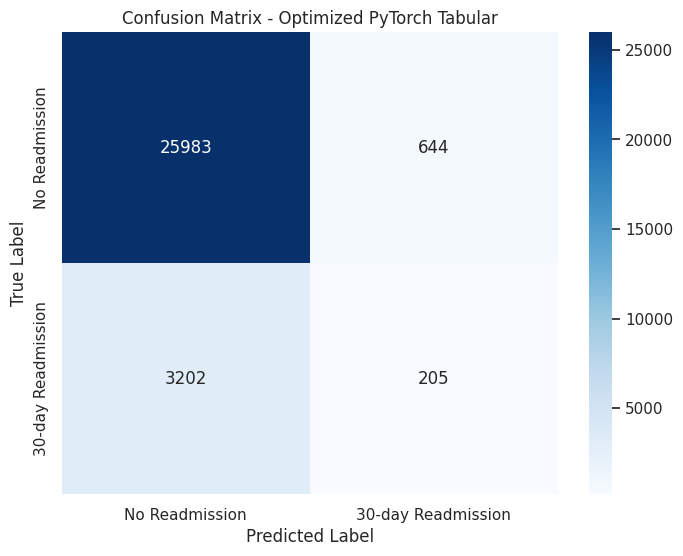


Confusion Matrix (PyTorch Tabular):
True Negatives: 25983
False Positives: 644
False Negatives: 3202
True Positives: 205


In [46]:
# Save the final PyTorch Tabular model
print("Saving PyTorch Tabular model...")

# Save the model
model_save_path = "best_pytorch_tabular_model"
final_model_pt.save_model(model_save_path)

# Also save the best hyperparameters
with open("best_pytorch_tabular_params.txt", "w") as f:
    f.write("Best PyTorch Tabular Hyperparameters:\n")
    f.write("="*50 + "\n")
    for key, value in study_pt.best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nBest CV Accuracy Score: {study_pt.best_value:.4f}\n")
    f.write(f"Final Test Accuracy Score: {final_accuracy_pt:.4f}\n")
    f.write(f"Final Test F1 Score: {final_f1_pt:.4f}\n")
    f.write(f"Final Test ROC-AUC: {final_auc_pt:.4f}\n")

print("Model and parameters saved successfully")

# Create confusion matrix for PyTorch Tabular
cm_pt = confusion_matrix(y_test_pt, final_pred_pt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized PyTorch Tabular')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix (PyTorch Tabular):")
print(f"True Negatives: {cm_pt[0,0]}")
print(f"False Positives: {cm_pt[0,1]}")
print(f"False Negatives: {cm_pt[1,0]}")
print(f"True Positives: {cm_pt[1,1]}")

In [47]:
# Compare XGBoost and PyTorch Tabular results
print("="*60)
print("MODEL COMPARISON: XGBoost vs PyTorch Tabular")
print("="*60)

print("\nCross-Validation Results (4-fold accuracy scores):")
print(f"XGBoost CV Accuracy:         {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")
print(f"PyTorch Tabular CV Accuracy: {np.mean(final_cv_scores_pt):.3f} ± {np.std(final_cv_scores_pt):.3f}")

print(f"\nTest Set Performance:")
print(f"{'Metric':<15} {'XGBoost':<10} {'PyTorch Tabular':<15}")
print("-" * 40)
print(f"{'Accuracy':<15} {test_accuracy:.3f}      {final_accuracy_pt:.3f}")
print(f"{'Precision':<15} {test_precision:.3f}      {final_prec_pt:.3f}")
print(f"{'Recall':<15} {test_recall:.3f}      {final_rec_pt:.3f}")
print(f"{'F1':<15} {test_f1:.3f}      {final_f1_pt:.3f}")
print(f"{'ROC-AUC':<15} {test_auc:.3f}      {final_auc_pt:.3f}")

print(f"\nBest Hyperparameters:")
print(f"\nXGBoost:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
    
print(f"\nPyTorch Tabular:")
for key, value in study_pt.best_params.items():
    print(f"  {key}: {value}")

print("\n" + "="*60)

MODEL COMPARISON: XGBoost vs PyTorch Tabular

Cross-Validation Results (4-fold accuracy scores):
XGBoost CV Accuracy:         0.881 ± 0.001
PyTorch Tabular CV Accuracy: 0.563 ± 0.237

Test Set Performance:
Metric          XGBoost    PyTorch Tabular
----------------------------------------
Accuracy        0.879      0.872
Precision       0.344      0.241
Recall          0.076      0.060
F1              0.124      0.096
ROC-AUC         0.632      0.603

Best Hyperparameters:

XGBoost:
  n_estimators: 854
  max_depth: 15
  learning_rate: 0.07877158071206303
  subsample: 0.7758717896165271
  colsample_bytree: 0.6274815514393598
  reg_alpha: 0.3169098246794778
  reg_lambda: 0.5336549996859082

PyTorch Tabular:
  layers_depth: 2
  layer_size: 256
  dropout: 0.20543906082887847
  learning_rate: 0.007589579618958715
  batch_size: 2048
  activation: ReLU

